## Data Ingestion

In [3]:
import os
import sys
import copy
import time
import random
import pyspark

from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, size, max, abs, split, col
from pyspark.sql.functions import datediff,unix_timestamp, round
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mizani.formatters import date_format
from plotnine import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

import warnings
warnings.filterwarnings('ignore')

Let's first load the csv files and have a look at their contents.

In [4]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [5]:
filename = "../data/machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

100
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model3| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model3|  2|
|        6|model3|  7|
|        7|model3| 20|
|        8|model3| 16|
|        9|model4|  7|
|       10|model3| 10|
|       11|model2|  6|
|       12|model3|  9|
|       13|model1| 15|
|       14|model3|  1|
|       15|model3| 14|
|       16|model1|  3|
|       17|model1| 14|
|       18|model3| 15|
|       19|model3| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [18]:
filename = "../data/errors.csv"
errors = spark.read.csv(filename, sep=',', header=True)
errors_pd = pd.read_csv(filename)

print(errors.count())
errors.show()

3919
+-------------------+---------+-------+
|           datetime|machineID|errorID|
+-------------------+---------+-------+
|2015-01-03 07:00:00|        1| error1|
|2015-01-03 20:00:00|        1| error3|
|2015-01-04 06:00:00|        1| error5|
|2015-01-10 15:00:00|        1| error4|
|2015-01-22 10:00:00|        1| error4|
|2015-01-25 15:00:00|        1| error4|
|2015-01-27 04:00:00|        1| error1|
|2015-03-03 22:00:00|        1| error2|
|2015-03-05 06:00:00|        1| error1|
|2015-03-20 18:00:00|        1| error1|
|2015-03-26 01:00:00|        1| error2|
|2015-03-31 23:00:00|        1| error1|
|2015-04-19 06:00:00|        1| error2|
|2015-04-19 06:00:00|        1| error3|
|2015-04-29 19:00:00|        1| error4|
|2015-05-04 23:00:00|        1| error2|
|2015-05-12 09:00:00|        1| error1|
|2015-05-21 07:00:00|        1| error4|
|2015-05-24 02:00:00|        1| error3|
|2015-05-25 05:00:00|        1| error1|
+-------------------+---------+-------+
only showing top 20 rows



In [7]:
filename = "../data/failures.csv"
failures  = spark.read.csv(filename, sep=',', header=True)

print(failures.count())
failures.show()

761
+-------------------+---------+-------+
|           datetime|machineID|failure|
+-------------------+---------+-------+
|2015-01-05 06:00:00|        1|  comp4|
|2015-03-06 06:00:00|        1|  comp1|
|2015-04-20 06:00:00|        1|  comp2|
|2015-06-19 06:00:00|        1|  comp4|
|2015-09-02 06:00:00|        1|  comp4|
|2015-10-17 06:00:00|        1|  comp2|
|2015-12-16 06:00:00|        1|  comp4|
|2015-03-19 06:00:00|        2|  comp1|
|2015-03-19 06:00:00|        2|  comp2|
|2015-04-18 06:00:00|        2|  comp2|
|2015-12-29 06:00:00|        2|  comp2|
|2015-01-07 06:00:00|        3|  comp2|
|2015-02-06 06:00:00|        3|  comp1|
|2015-07-21 06:00:00|        3|  comp2|
|2015-10-04 06:00:00|        3|  comp2|
|2015-12-03 06:00:00|        3|  comp2|
|2015-01-17 06:00:00|        4|  comp2|
|2015-02-16 06:00:00|        4|  comp1|
|2015-04-02 06:00:00|        4|  comp2|
|2015-07-16 06:00:00|        4|  comp2|
+-------------------+---------+-------+
only showing top 20 rows



In [8]:
filename = "../data/maint.csv"
maintenance  = spark.read.csv(filename, sep=',', header=True)

print(maintenance.count())
maintenance.show()

3286
+-------------------+---------+-----+
|           datetime|machineID| comp|
+-------------------+---------+-----+
|2014-06-01 06:00:00|        1|comp2|
|2014-07-16 06:00:00|        1|comp4|
|2014-07-31 06:00:00|        1|comp3|
|2014-12-13 06:00:00|        1|comp1|
|2015-01-05 06:00:00|        1|comp4|
|2015-01-05 06:00:00|        1|comp1|
|2015-01-20 06:00:00|        1|comp3|
|2015-01-20 06:00:00|        1|comp1|
|2015-02-04 06:00:00|        1|comp4|
|2015-02-04 06:00:00|        1|comp3|
|2015-02-19 06:00:00|        1|comp3|
|2015-03-06 06:00:00|        1|comp1|
|2015-03-21 06:00:00|        1|comp1|
|2015-04-05 06:00:00|        1|comp3|
|2015-04-20 06:00:00|        1|comp2|
|2015-05-05 06:00:00|        1|comp3|
|2015-05-05 06:00:00|        1|comp2|
|2015-05-20 06:00:00|        1|comp2|
|2015-06-04 06:00:00|        1|comp3|
|2015-06-19 06:00:00|        1|comp1|
+-------------------+---------+-----+
only showing top 20 rows



In [9]:
filename = "../data/telemetry.csv"
telemetry = spark.read.csv(filename, sep=',', header=True)
telemetry_pd = pd.read_csv(filename)

print(telemetry.count())
telemetry.limit(10).toPandas().head(10)

876100


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853015625,418.504078221616,113.077935462083,45.0876857639276
1,2015-01-01 07:00:00,1,162.87922289706,402.747489565395,95.4605253823187,43.4139726834815
2,2015-01-01 08:00:00,1,170.989902405567,527.349825452291,75.2379048586662,34.1788471214451
3,2015-01-01 09:00:00,1,162.462833264092,346.149335043074,109.248561276504,41.1221440884256
4,2015-01-01 10:00:00,1,157.61002119306,435.376873016938,111.886648210168,25.9905109982024
5,2015-01-01 11:00:00,1,172.504839196295,430.323362106675,95.9270416939636,35.6550173268837
6,2015-01-01 12:00:00,1,156.556030606329,499.071623068962,111.755684290096,42.7539196974773
7,2015-01-01 13:00:00,1,172.522780814836,409.624717000438,101.00108276407,35.4820086610704
8,2015-01-01 14:00:00,1,175.324523915223,398.648780707752,110.624360548654,45.4822868466294
9,2015-01-01 15:00:00,1,169.218423246933,460.850669930244,104.848229967003,39.9017354356787


All data is loaded up. How does the telemetry data vary with time?

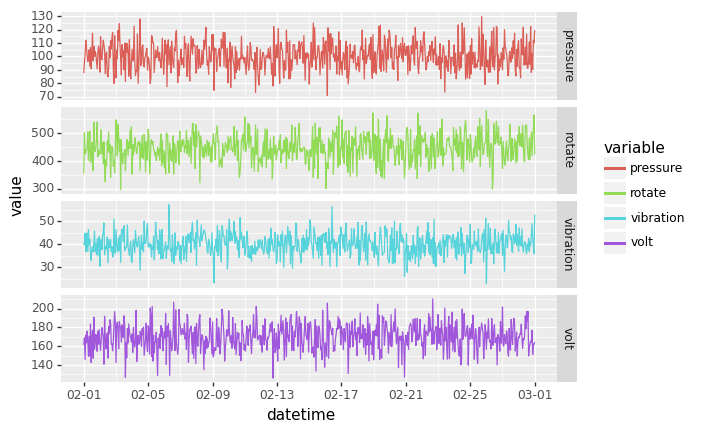

<ggplot: (8726992537846)>

In [10]:
plt_data = telemetry_pd.loc[telemetry_pd['machineID'] == 1]

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")


# Quick plot to show structure
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data) +\
    geom_line() +\
    scale_x_date(labels=date_format('%m-%d')) +\
    facet_grid('variable ~ .', scales='free_y')

There is no clear pattern here, they all vary randomly.

Let's define some functions that will help us to plot.

In [11]:
def plot_ts(series, figsize=(40, 20), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_ts2(ax, values, times, label=None, color='blue', xmin=None, xmax=None, ymin=None, ymax=None, anomalies=None):
    step = 700
    if xmin is not None:
        assert(xmax is not None)
        ax.set(xlim=(xmin, xmax))
    if ymin is not None:
        assert(ymax is not None)
        ax.set(ylim=(ymin, ymax))
    if xmin is None:
        ax.set_xticks([i for i in range(len(values)) if i % step == 0])
        ax.set_xticklabels([times[i] for i in range(len(values)) if i % step == 0])
    ax.plot(values, label=label, color=color)
    if anomalies is not None:
        x, y = anomalies
        ax.scatter(x, y, label='Anomalies', color='red')
    if label is not None:
        ax.legend()

Next, we plot how the vibration varies for Machine 1.

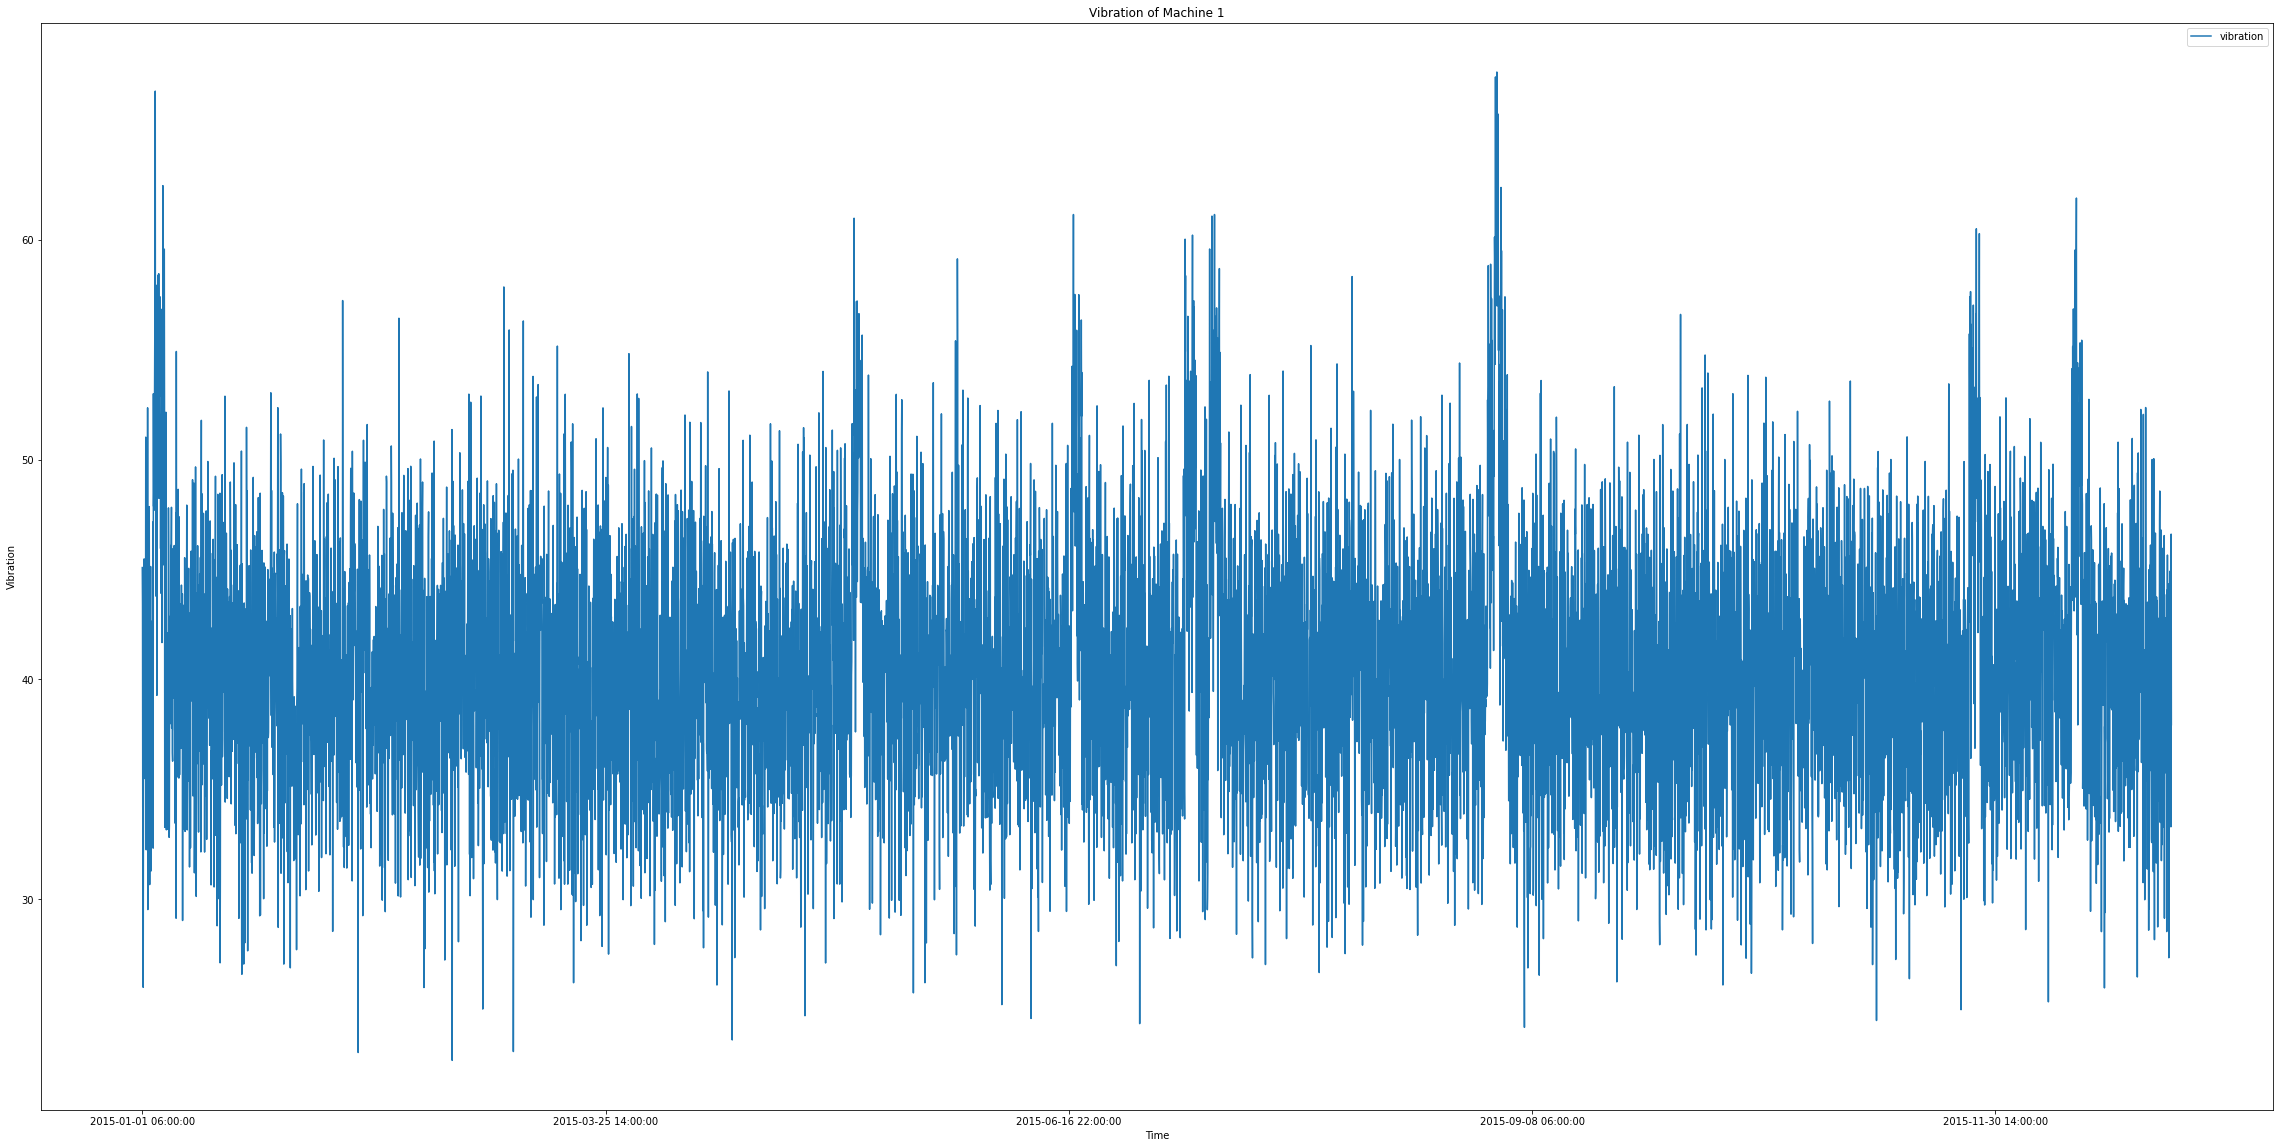

In [12]:
#telemetry_values = telemetry['volt']
#telemetry_dates = telemetry['datetime']
#plot_ts(ax, telemetry_values, telemetry_dates, label="volt", color='green')

df_vib_machine_1 = telemetry_pd[
    telemetry_pd.machineID == 1][["datetime", "vibration"]].set_index("datetime")

plot_ts(df_vib_machine_1, title="Vibration of Machine 1", xlabel="Time", ylabel="Vibration")

How many unique machines are there?

In [14]:
telemetry_pd.machineID.nunique()

100

Are there null values?

In [17]:
telemetry_pd.isna().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

Which errors are the most common?

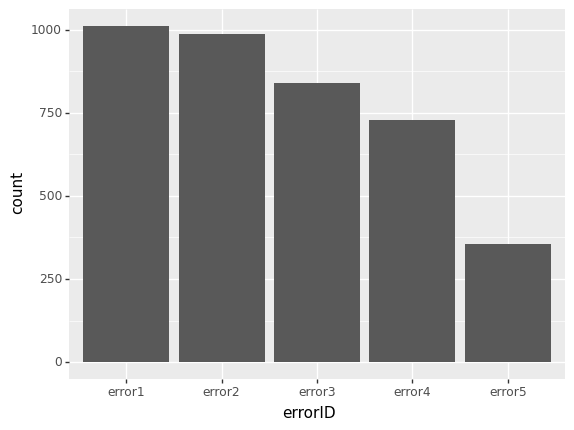

<ggplot: (-9223363309862604407)>

In [23]:
ggplot(aes(x="errorID"), errors_pd) + geom_bar()

As we can see error1 is the most common.

# Feature Engineering - Time Window

In [18]:
# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Engineer features
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
# test = tel_mean.withColumn("dt_truncated", dt_truncated).drop('volt', 'rotate', 'pressure', 'vibration').show()
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [19]:
lags = [12, 24, 36] #in hours

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))

print(tel_mean.count())
print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 2)).limit(20).toPandas().head(20)

876100
73100


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,pressure_rollingstd_12,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36
0,2,2015-01-01 12:00:00,173.018270,438.769815,95.391335,41.294958,173.018270,438.769815,95.391335,41.294958,...,5.565023,1.610592,3.301201,13.778898,5.565023,1.610592,3.301201,13.778898,5.565023,1.610592
1,2,2015-01-02 00:00:00,173.244138,445.493266,100.264009,41.895812,173.516975,443.902668,99.597583,41.575415,...,1.002215,0.804405,0.769889,3.063019,0.312693,0.168758,0.769889,3.063019,0.312693,0.168758
2,2,2015-01-02 12:00:00,168.515602,439.213284,95.893927,40.631988,170.879870,442.353275,98.078968,41.263900,...,0.777550,0.601375,0.655344,4.142932,0.278703,0.222544,0.414646,2.803480,0.168137,0.205687
3,2,2015-01-03 00:00:00,170.609688,464.642626,96.237027,40.491591,169.562645,451.927955,96.065477,40.561790,...,1.561531,0.543683,0.402886,3.358894,0.566059,0.094310,0.229611,2.560276,0.401070,0.092042
4,2,2015-01-03 12:00:00,175.383076,453.537553,101.233945,40.173800,172.996382,459.090090,98.735486,40.332695,...,1.387805,0.747395,0.625652,5.399355,0.477364,0.591488,0.807811,1.328102,0.419718,0.174513
5,2,2015-01-04 00:00:00,177.709770,455.701935,102.002122,39.833452,176.546423,454.619744,101.618034,40.003626,...,0.441225,0.801574,0.449098,3.160038,0.275383,0.263018,0.283309,2.583867,0.237033,0.252539
6,2,2015-01-04 12:00:00,171.616568,451.630935,103.808091,41.258635,174.663169,453.666435,102.905106,40.546044,...,1.172641,0.608804,0.248107,1.955244,0.634153,0.549950,0.350877,3.549629,0.505622,0.249132
7,2,2015-01-05 00:00:00,172.988222,451.574824,98.897324,40.622196,172.302395,451.602880,101.352708,40.940416,...,1.429336,0.454397,0.344418,1.874899,0.352727,0.248690,0.356872,2.693029,0.300359,0.248281
8,2,2015-01-05 12:00:00,173.302887,456.220884,101.402805,42.034326,173.145554,453.897854,100.150065,41.328261,...,0.683110,0.850085,0.611437,3.768882,0.633284,0.446886,0.399975,1.770197,0.188933,0.191291
9,2,2015-01-06 00:00:00,170.662418,451.417659,104.586007,40.317308,171.982652,453.819271,102.994406,41.175817,...,0.584043,0.545889,0.830284,3.903712,0.438185,0.518611,0.863927,1.299080,0.366734,0.378901


In [20]:
# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+'_rollingmean_24', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

73100


,machineID,dt_truncated,error1sum_rollingmean_24,error2sum_rollingmean_24,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24
0,51,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
1,51,2015-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0
2,51,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
3,51,2015-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0
4,51,2015-01-03 12:00:00,0.0,0.0,0.0,0.0,0.0
5,51,2015-01-04 00:00:00,0.0,0.0,0.0,0.0,0.0
6,51,2015-01-04 12:00:00,0.0,0.0,0.0,0.0,0.0
7,51,2015-01-05 00:00:00,0.0,0.0,0.0,0.0,0.0
8,51,2015-01-05 12:00:00,0.0,0.0,0.0,0.0,0.0
9,51,2015-01-06 00:00:00,0.0,0.0,0.0,0.0,0.0


In [21]:
# create a column for each component replacement
maint_replace = (maintenance.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

2528


,machineID,datetime_maint,comp1sum,comp2sum,comp3sum,comp4sum
0,41,2015-08-30 06:00:00,0,0,1,0
1,99,2015-04-03 06:00:00,0,1,0,0
2,7,2015-02-08 06:00:00,1,1,0,0
3,39,2015-05-16 06:00:00,1,0,0,0
4,53,2015-02-12 06:00:00,0,0,0,1
5,26,2015-03-07 06:00:00,0,1,0,0
6,98,2015-05-15 06:00:00,1,0,0,0
7,1,2015-02-04 06:00:00,0,0,1,1
8,77,2015-04-26 06:00:00,1,0,1,0
9,23,2015-02-04 06:00:00,1,0,0,0


In [22]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)\
                    .withColumnRenamed('dt_truncated','datetime_tel')

# Grab 4 component
for i in range(4):
    maint_comp = maint_replace.where(col(f'comp{i+1}sum') == '1')\
                    .withColumnRenamed('datetime','datetime_maint')\
                    .drop(f'comp{(i+1)%4+1}sum', f'comp{(i+2)%4+1}sum', f'comp{(i+3)%4+1}sum')

    # Within each machine, get the last replacement date for each timepoint
    maint_tel_comp = telemetry_times.join(maint_comp, 
                    ((telemetry_times['machineID']== maint_comp['machineID']) 
                    & (telemetry_times['datetime_tel'] > maint_comp['datetime_maint'])
                    & ( maint_comp[f'comp{i+1}sum'] == '1')))\
                       .drop(maint_comp.machineID)

    # Calculate the number of days between replacements
    comp = maint_tel_comp.withColumn(f'sincelastcomp{i+1}', 
            datediff(maint_tel_comp.datetime_tel, maint_tel_comp.datetime_maint))\
            .drop(maint_tel_comp.datetime_maint).drop(maint_tel_comp[f'comp{i+1}sum'])
    #print(comp.count())
    #comp.filter(comp.machineID == '1').orderBy(comp.datetime_tel).limit(20).toPandas().head(20)
    
    # Join component
    if i+1 == 1:
        comps_feat = comp
    else:
        comps_feat = (comps_feat.join(comp, 
            ((comps_feat['machineID'] == comp['machineID']) & 
             (comps_feat['datetime_tel'] == comp['datetime_tel'])), "left")\
           .drop(comp.machineID).drop(comp.datetime_tel))
    
comps_feat = comps_feat.groupBy("machineID", "datetime_tel")\
                   .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                        F.max('sincelastcomp2').alias('sincelastcomp2'), 
                        F.max('sincelastcomp3').alias('sincelastcomp3'), 
                        F.max('sincelastcomp4').alias('sincelastcomp4'))\
                   .fillna(0)
comps_feat.filter(comps_feat.machineID == '1').orderBy(comps_feat.datetime_tel).limit(20).toPandas().head(20)

,machineID,datetime_tel,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4
0,1,2015-01-01 12:00:00,19,214,154,169
1,1,2015-01-02 00:00:00,20,215,155,170
2,1,2015-01-02 12:00:00,20,215,155,170
3,1,2015-01-03 00:00:00,21,216,156,171
4,1,2015-01-03 12:00:00,21,216,156,171
5,1,2015-01-04 00:00:00,22,217,157,172
6,1,2015-01-04 12:00:00,22,217,157,172
7,1,2015-01-05 00:00:00,23,218,158,173
8,1,2015-01-05 12:00:00,23,218,158,173
9,1,2015-01-06 00:00:00,24,219,159,174


In [23]:
# Choose the time_val hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

73100


,machineID,dt_truncated,comp1sum,comp2sum,comp3sum,comp4sum
0,1,2015-01-12 12:00:00,30.0,225.0,165.0,180.0
1,1,2015-06-03 12:00:00,172.0,367.0,307.0,322.0
2,1,2015-09-19 12:00:00,280.0,475.0,415.0,430.0
3,10,2015-02-22 00:00:00,131.0,176.0,251.0,146.0
4,10,2015-04-03 00:00:00,171.0,216.0,291.0,186.0
5,10,2015-08-30 12:00:00,320.0,365.0,440.0,335.0
6,10,2015-10-15 12:00:00,366.0,411.0,486.0,381.0
7,10,2015-11-28 12:00:00,410.0,455.0,530.0,425.0
8,100,2015-03-28 00:00:00,195.0,105.0,120.0,210.0
9,100,2015-04-18 12:00:00,216.0,126.0,141.0,231.0


In [24]:
# one hot encoding of the machine's model
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

100


,machineID,model,age,model_encoded
0,1,model3,18,"(1.0, 0.0, 0.0)"
1,2,model4,7,"(0.0, 1.0, 0.0)"
2,3,model3,8,"(1.0, 0.0, 0.0)"
3,4,model3,7,"(1.0, 0.0, 0.0)"
4,5,model3,2,"(1.0, 0.0, 0.0)"
5,6,model3,7,"(1.0, 0.0, 0.0)"
6,7,model3,20,"(1.0, 0.0, 0.0)"
7,8,model3,16,"(1.0, 0.0, 0.0)"
8,9,model4,7,"(0.0, 1.0, 0.0)"
9,10,model3,10,"(1.0, 0.0, 0.0)"


In [25]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))

print(final_feat.count())
final_feat.filter(final_feat.machineID == '1').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

73100


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded
0,2015-01-01 12:00:00,168.230981,428.889639,102.153706,39.927856,168.230981,428.889639,102.153706,39.927856,168.230981,...,0.000000,0.0,0.000000,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
1,2015-01-02 00:00:00,168.476346,446.601319,96.316365,40.618666,167.922496,440.043412,98.534414,40.048817,167.922496,...,0.000000,0.0,0.000000,20.0,215.0,155.0,170.0,model3,18,"(1.0, 0.0, 0.0)"
2,2015-01-02 12:00:00,172.469820,447.396678,97.164049,39.212348,170.473083,446.998999,96.740207,39.915507,169.854731,...,0.000000,0.0,0.000000,20.0,215.0,155.0,170.0,model3,18,"(1.0, 0.0, 0.0)"
3,2015-01-03 00:00:00,167.128130,454.743644,101.793694,39.154459,169.798975,451.070161,99.478872,39.183403,169.358098,...,0.000000,0.0,0.000000,21.0,216.0,156.0,171.0,model3,18,"(1.0, 0.0, 0.0)"
4,2015-01-03 12:00:00,175.144693,470.929443,97.089573,45.566071,171.136411,462.836544,99.441633,42.360265,171.580881,...,0.000000,0.0,0.000000,21.0,216.0,156.0,171.0,model3,18,"(1.0, 0.0, 0.0)"
5,2015-01-04 00:00:00,169.280323,443.722253,99.130397,51.892909,172.212508,457.325848,98.109985,48.729490,170.517715,...,0.034722,0.0,0.000000,22.0,217.0,157.0,172.0,model3,18,"(1.0, 0.0, 0.0)"
6,2015-01-04 12:00:00,172.930013,446.833128,104.227393,52.781847,171.105168,445.277691,101.678895,52.337378,172.451676,...,0.041667,0.0,0.041667,22.0,217.0,157.0,172.0,model3,18,"(1.0, 0.0, 0.0)"
7,2015-01-05 00:00:00,173.302702,440.586352,96.800228,50.858178,173.116358,443.709740,100.513810,51.820013,171.837679,...,0.006944,0.0,0.041667,23.0,218.0,158.0,173.0,model3,18,"(1.0, 0.0, 0.0)"
8,2015-01-05 12:00:00,170.844178,446.190872,102.973673,46.499854,172.073440,443.388612,99.886950,48.679016,172.358965,...,0.000000,0.0,0.000000,23.0,218.0,158.0,173.0,model3,18,"(1.0, 0.0, 0.0)"
9,2015-01-06 00:00:00,173.248541,470.415999,102.542720,39.505734,172.046360,458.303436,102.758196,43.002794,172.465140,...,0.000000,0.0,0.000000,24.0,219.0,159.0,174.0,model3,18,"(1.0, 0.0, 0.0)"


# Label construction

In [26]:
# time_val = 12*3600 #Not always correct
# dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))
# fail_diff = failures.withColumn("dt_truncated", dt_truncated) #wrong
# fail_diff = telemetry.withColumn("dt_truncated", dt_truncated) #correct
# spark.conf.set("spark.sql.session.timeZone", "UTC")

dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))
fail_diff = (failures.withColumn("dt_truncated", dt_truncated)
             .drop(failures.datetime))

print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)

761


,machineID,failure,dt_truncated
0,1,comp4,2015-01-05 12:00:00
1,1,comp1,2015-03-06 12:00:00
2,1,comp2,2015-04-20 12:00:00
3,1,comp4,2015-06-19 12:00:00
4,1,comp4,2015-09-02 12:00:00
5,1,comp2,2015-10-17 12:00:00
6,1,comp4,2015-12-16 12:00:00
7,2,comp1,2015-03-19 12:00:00
8,2,comp2,2015-03-19 12:00:00
9,2,comp2,2015-04-18 12:00:00


In [28]:
# map the failure data to final feature matrix
labeled_features = (final_feat.join(fail_diff, 
                                    ((final_feat['machineID'] == fail_diff['machineID']) 
                                     & (final_feat['dt_truncated'] == fail_diff['dt_truncated'])), "left")
                    .drop(fail_diff.machineID).drop(fail_diff.dt_truncated)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                                                labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

In [ ]:
print(labeled_features.count())

In [29]:
print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

KeyboardInterrupt: 

In [ ]:
# To get the frequency of each component failure 
df = labeled_features.select(labeled_features.failure).toPandas()
df['failure'].value_counts()

In [ ]:
# lag values to manually backfill label (bfill =7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# Create the previous 7 days 
for i in range(7):
    if i==0:
        labeled_features = (labeled_features.withColumn(f'prev_value{i+1}', 
                                                F.lag(labeled_features.failure).
                                                over(my_window)).fillna(0))
    else:
        labeled_features = (labeled_features.withColumn(f'prev_value{i+1}', 
                                                F.lag(labeled_features[f'prev_value{i}']).
                                                over(my_window)).fillna(0))

# Create a label features
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + 
                                                labeled_features.prev_value1 +
                                                labeled_features.prev_value2 +
                                                labeled_features.prev_value3 +
                                                labeled_features.prev_value4 +
                                                labeled_features.prev_value5 + 
                                                labeled_features.prev_value6 + 
                                                labeled_features.prev_value7))

# Restrict the label to be on the range of 0:4, and remove extra columns
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0)
                                                .otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

In [31]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID ~ .')

TypeError: Continuous value supplied to discrete scale

In [67]:
# Save finalized data
labeled_features.write.mode('overwrite').parquet('../data/labeled_features.parquet')


In [70]:
# Test loader
parquetFile = spark.read.parquet('../data/labeled_features.parquet')
print(parquetFile.count())
parquetFile.limit(10).toPandas().head(10)

73142


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,2016-01-01 12:00:00,172.083928,453.576897,101.303110,40.627410,169.230878,451.007306,100.487259,40.839262,167.339602,...,0.0,579.0,534.0,474.0,459.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
1,2016-01-01 00:00:00,168.173348,453.181951,99.527531,40.981132,165.787189,449.842118,100.598808,41.791947,166.190766,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
2,2015-12-31 12:00:00,163.401030,446.502286,101.670084,42.602762,165.199475,445.038344,101.074817,41.722713,168.995817,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-31 00:00:00,166.997919,443.574402,100.479550,40.842664,171.793211,450.456864,100.955598,40.418503,172.419415,...,0.0,577.0,532.0,472.0,457.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-30 12:00:00,176.588502,457.339327,101.431647,39.994342,175.130162,466.483595,99.468624,40.920312,174.914358,...,0.0,577.0,532.0,472.0,457.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-30 00:00:00,173.671822,475.627863,97.505602,41.846282,174.077285,464.681249,99.852795,41.520096,173.561514,...,0.0,576.0,531.0,471.0,456.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-29 12:00:00,174.482749,453.734636,102.199989,41.193909,173.506360,450.268077,101.890206,39.760938,173.318924,...,0.0,576.0,531.0,471.0,456.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-29 00:00:00,172.529971,446.801518,101.580424,38.327966,172.737011,443.114257,99.159233,38.946824,171.416655,...,0.0,575.0,530.0,470.0,455.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-28 12:00:00,172.944052,439.426996,96.738042,39.565681,170.859997,444.430674,99.034004,39.874349,172.384220,...,0.0,575.0,530.0,470.0,455.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-28 00:00:00,168.775941,449.434352,101.329965,40.183016,172.104304,444.571586,98.413556,39.550401,170.807337,...,0.0,574.0,529.0,469.0,454.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
